____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
cropping2d_2 (Cropping2D)        (None, 65, 320, 3)    0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 61, 316, 24)   1824        cropping2d_2[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 61, 316, 24)   0           convolution2d_5[0][0]            
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3456/3346 [==============================] - 15s - loss: 1.1438 - val_loss: 0.0262
Epoch 2/5
3456/3346 [==============================] - 15s - loss: 0.0300 - val_loss: 0.0200
Epoch 3/5
3456/3346 [==============================] - 15s - loss: 0.0246 - val_loss: 0.0187
Epoch 4/5
3456/3346 [==============================] - 15s - loss: 0.0247 - val_loss: 0.0157
Epoch 5/5
3456/3346 [==============================] - 15s - loss: 0.0246 - val_loss: 0.0168
dict_keys(['val_loss', 'loss'])


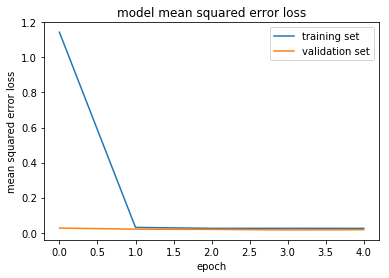

In [2]:
%matplotlib inline
import csv
import cv2
import numpy as np

lines = []
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

import sklearn.utils
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

correction = 0.2

def flip_image_angle(image, angle, images, angles):
    images.append(cv2.flip(image, 1))
    angles.append(angle*-1.0)

def add_image_angle(image, angle, images, angles):
    images.append(image)
    angles.append(angle)
    
def add_and_flip_data(image, angle, images, angles):
    add_image_angle(image, angle, images, angles)
    flip_image_angle(image, angle, images, angles)
    
def read_image(path):
    name = '../data/IMG/' + path.split('/')[-1]
    return cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    

def generator(samples, use_left_right_image, batch_size=32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples, random_state=20)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])                
                add_and_flip_data(read_image(batch_sample[0]), center_angle, images, angles)
                if use_left_right_image:
                    add_and_flip_data(read_image(batch_sample[1]), center_angle + correction, images, angles) # left
                    add_and_flip_data(read_image(batch_sample[2]), center_angle - correction, images, angles) # right
                    
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train, random_state=20)

train_generator = generator(train_samples, True, batch_size=32)
validation_generator = generator(validation_samples, False, batch_size=32)


from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

#https://faroit.github.io/keras-docs/1.0.1/layers/convolutional/#convolution2d

model= Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))

model.add(Convolution2D(24, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Convolution2D(36, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Convolution2D(48, 5, 5))
model.add(Activation('relu'))

model.add(Convolution2D(64, 5, 5))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch = len(train_samples),
        validation_data = validation_generator, nb_val_samples = len(validation_samples), nb_epoch=5, verbose=1)

model.save('model.h5')

print(history_object.history.keys())

import matplotlib.pyplot as plt

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

        
